In [1]:
import tensorflow as tf
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

# Define commands and paths
commands = ['up', 'down', 'left', 'right']
data_dir = 'E:/study/رابعه/Machine Learning/project/Learn App/Train motions'

# Helper function to load audio files
def load_audio_files(data_dir, commands):
    audio_data = []
    labels = []
    for label, command in enumerate(commands):
        command_path = os.path.join(data_dir, command)
        for file in os.listdir(command_path):
            try:
                file_path = os.path.join(command_path, file)
                audio, sr = librosa.load(file_path, sr=16000)
                audio_data.append(audio)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return np.array(audio_data, dtype=object), np.array(labels)

# Load the data
audio_data, labels = load_audio_files(data_dir, commands)


In [2]:
def extract_features(audio_data, max_length=16000):
    features = []
    for audio in audio_data:
        # Pad or truncate audio to fixed length
        audio = librosa.util.fix_length(audio, size=max_length)
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
        features.append(mfcc)
    return np.array(features)

# Extract features
features = extract_features(audio_data)

# Normalize and reshape
features = np.expand_dims(features, -1)  # Add channel dimension for CNN
labels = tf.keras.utils.to_categorical(labels, num_classes=len(commands))

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [3]:
from tensorflow.keras import layers, models

def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the model
input_shape = X_train.shape[1:]  # e.g., (40, 100, 1)
model = build_model(input_shape, len(commands))


d:\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.4818 - loss: 2.5548 - val_accuracy: 0.8844 - val_loss: 0.3477
Epoch 2/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8660 - loss: 0.3653 - val_accuracy: 0.9139 - val_loss: 0.2348
Epoch 3/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9267 - loss: 0.2054 - val_accuracy: 0.9451 - val_loss: 0.1546
Epoch 4/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9469 - loss: 0.1439 - val_accuracy: 0.9507 - val_loss: 0.1447
Epoch 5/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9575 - loss: 0.1258 - val_accuracy: 0.9478 - val_loss: 0.1501
Epoch 6/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9681 - loss: 0.0863 - val_accuracy: 0.9435 - val_loss: 0.1572
Epoch 7/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9760 - loss: 0.0690 - val_accuracy: 0.9583 - val_loss: 0.1410
Epoch 8/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9763 - loss: 0.0695 - val_acc

In [5]:
model.save('motions.h5')

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9508 - loss: 0.3271
Test Accuracy: 95.80%


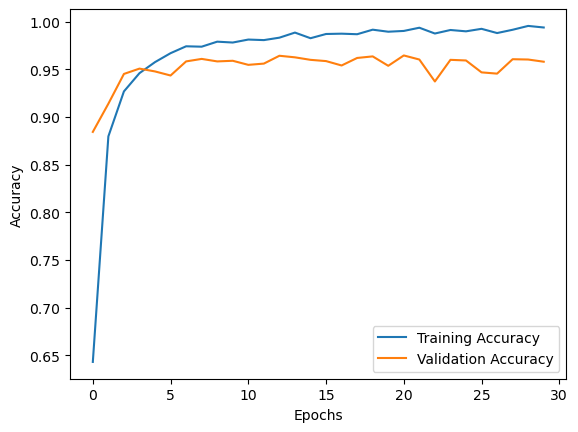

In [6]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Visualize training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [12]:
import sounddevice as sd
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to record audio
def record_audio(duration=2, sample_rate=16000):
    print("Recording...")
    audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='int16')
    sd.wait()  # Wait until recording is finished
    print("Recording complete.")
    return audio_data.flatten(), sample_rate

# Convert audio data to floating-point and normalize
def normalize_audio(audio):
    return audio.astype(np.float32) / 32768.0  # Normalize to range [-1, 1]

# Extract MFCC features from the audio
def extract_mfcc(audio, sr, duration=2, n_mfcc=40, frames=32):
    # Normalize the audio
    audio = normalize_audio(audio)
    
    # Extract MFCC features from audio
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # Ensure the MFCC has the right number of frames (pad or trim)
    if mfcc.shape[1] < frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, frames - mfcc.shape[1])), mode='constant')
    elif mfcc.shape[1] > frames:
        mfcc = mfcc[:, :frames]
    
    # Reshape to match model input (1, 40, 32, 1)
    mfcc = np.expand_dims(mfcc, axis=-1)  # Add channel dimension
    mfcc = np.expand_dims(mfcc, axis=0)  # Add batch dimension
    
    return mfcc

# Function to recognize command from recorded audio
def recognize_command_from_microphone(model, duration=2, commands=None):
    # Record audio
    audio, sr = record_audio(duration=duration)

    # Extract MFCC features
    mfcc = extract_mfcc(audio, sr, duration)
    
    print(f"MFCC shape: {mfcc.shape}")  # Check MFCC shape
    
    # Predict the command
    prediction = model.predict(mfcc)
    predicted_command = commands[np.argmax(prediction)]  # Get the label with the highest prediction score

    print(f"Recognized Command: {predicted_command}")

# Example usage
commands = ['up', 'down', 'left', 'right']  # List of your command labels
model = load_model('motions.h5')  # Load your trained model
recognize_command_from_microphone(model, duration=2, commands=commands)


Recording...
Recording complete.
MFCC shape: (1, 40, 32, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Recognized Command: right
